In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime



In [2]:
OPTIMAL_SCORE = 100.0   

In [3]:
def load_results(results_file):
    """Load results from JSON file"""
    with open(results_file, 'r') as f:
        return json.load(f)

def analyze_results(results, optimal_score):
    """Analyze results and return statistics"""
    stats = {}
    
    for method_key, trials in results.items():
        # Extract best scores and histories
        best_scores = [trial['best_score'] for trial in trials]
        score_histories = [trial['best_score_history'] for trial in trials]

        # Filter out inf scores and below optimal score
        best_scores = [score for score in best_scores if score != np.inf and score <= optimal_score]
        score_histories = [history for history in score_histories if np.mean(history) <= optimal_score]

        # Filter out best scores and score histories if steps are less than 5
        best_scores = [score for i, score in enumerate(best_scores) if len(score_histories[i]) >= 1]
        score_histories = [history for history in score_histories if len(history) >= 1]
        
        # Calculate average scores across trials
        avg_scores = np.mean([np.mean(history) for history in score_histories])
        
        # Calculate average number of steps to best solution
        avg_steps = np.mean([len(history) for history in score_histories])
        std_steps = np.std([len(history) for history in score_histories])
        
        # Calculate optimality gap
        gaps = [np.abs(score - optimal_score)/optimal_score for score in best_scores]
        avg_gap = np.mean(gaps)
        std_gap = np.std(gaps)
        
        # Calculate statistics
        if len(best_scores) > 0:        
            stats[method_key] = {
                'mean_score': np.mean(best_scores),
                'std_score': np.std(best_scores),
                'min_score': np.min(best_scores), 
                'max_score': np.max(best_scores),
                'avg_score': avg_scores,
                'avg_steps': avg_steps,
                'std_steps': std_steps,
                'optimality_gap': avg_gap,
                'std_gap': std_gap
        }
    
    return stats

def plot_convergence(results, optimal_score):
    """Plot convergence curves for all methods"""
    plt.figure(figsize=(12, 6))
    # plot optimal score
    plt.axhline(y=optimal_score, color='black', linestyle='--', label='Optimal Score')  

    # put different markers and colors  for each method
    markers = ['o', 's', 'D', 'P', 'X', 'v', 'd', 'h']
    #colors = ['blue', 'green', 'red', 'purple', 'orange']
    k = 0
    for method_key, trials in results.items():
        marker = markers[k]
        k += 1
        # Find best trial based on best score, but not below optimal scor
        # If there are identical best scores, choose with less steps (len(score_history))
        best_trial = max(trials, key=lambda x: (x['best_score'], len(x['best_score_history'])))
        #while best_trial['best_score'] > optimal_score:
        #    trials.remove(best_trial)

        # Plot only the best trial
        if best_trial['best_score_history']:
            # Remove score history that is below optimal score
            best_trial['best_score_history'] = [score for score in best_trial['best_score_history'] if score <= optimal_score]
            plt.plot(best_trial['best_score_history'],
                    label=f'{method_key} (Best Trial)',
                    alpha=0.7, 
                    marker=marker)
    
    plt.xlabel('Step')
    plt.ylabel('Best Score')
    plt.title('TSP Optimization Convergence')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_method_comparison(stats):
    """Plot comparison of methods using box plots"""
    methods = list(stats.keys())
    scores = []
    labels = []
    
    for method_key in methods:
        method_scores = stats[method_key]['mean_score']
        scores.append(method_scores)
        labels.extend([method_key])
    
    plt.figure(figsize=(10, 6))
    plt.boxplot(scores, labels=methods)
    plt.xticks(rotation=45)
    plt.xlabel('Method')
    plt.ylabel('Best Score')
    plt.title('Method Comparison')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_statistics(stats):
    """Print statistical analysis results"""
    print("\nStatistical Analysis:")
    print("=" * 100)
    print(f"{'Method':<30} {'Mean Score':<12} {'Std Dev':<12} {'Opt Gap':<12} {'Opt Gap Std':<12} {'Avg Steps':<12} {'Steps Std':<12}")
    print("-" * 100)
    
    for method_key, stat in stats.items():
        print(f"{method_key:<30} "
              f"{stat['mean_score']:>12.2f} "
              f"{stat['std_score']:>12.2f} "
              f"{stat['optimality_gap']:>12.2%} "
              f"{stat['std_gap']:>12.2%} "
              f"{stat['avg_steps']:>12.1f} "
              f"{stat['std_steps']:>12.1f}")
        
    print("\nDetailed Statistics:")
    print("=" * 100)
    for method_key, stat in stats.items():
        print(f"\n{method_key}:")
        print(f"  Mean score: {stat['mean_score']:.2f} ± {stat['std_score']:.2f}")
        print(f"  Optimality gap: {stat['optimality_gap']:.2%} ± {stat['std_gap']:.2%}")
        print(f"  Average steps to best: {stat['avg_steps']:.1f} ± {stat['std_steps']:.1f}")



In [4]:
# Get the most recent results file
results_dir = Path('results')
results_files = list(results_dir.glob('tsp_results_*.json'))


# Combine all results files
all_results = {}
for file in results_files:
    results = load_results(file)
    all_results.update(results)


In [5]:
# Load and analyze results
results = all_results
stats = analyze_results(results, optimal_score=OPTIMAL_SCORE)



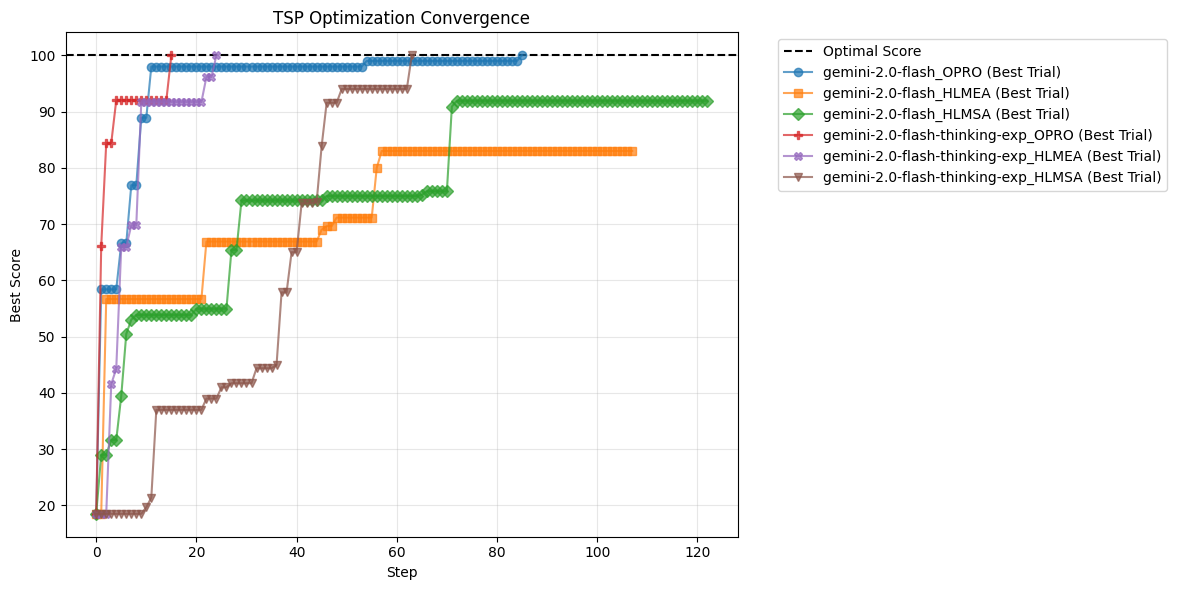

In [6]:
# Generate visualizations
plot_convergence(results, optimal_score=OPTIMAL_SCORE)


In [7]:
#plot_method_comparison(stats)



In [8]:
# Print statistics
print_statistics(stats)


Statistical Analysis:
Method                         Mean Score   Std Dev      Opt Gap      Opt Gap Std  Avg Steps    Steps Std   
----------------------------------------------------------------------------------------------------
gemini-2.0-flash_OPRO                100.00         0.00        0.00%        0.00%         31.4         27.9
gemini-2.0-flash_HLMEA                54.46        23.85       45.54%       23.85%         65.0         21.5
gemini-2.0-flash_HLMSA                58.64        26.71       41.36%       26.71%         71.0         26.6
gemini-2.0-flash-thinking-exp_OPRO       100.00         0.00        0.00%        0.00%         12.2          2.3
gemini-2.0-flash-thinking-exp_HLMEA        97.40         4.72        2.60%        4.72%         55.8         50.4
gemini-2.0-flash-thinking-exp_HLMSA       100.00         0.00        0.00%        0.00%         32.2         19.5

Detailed Statistics:

gemini-2.0-flash_OPRO:
  Mean score: 100.00 ± 0.00
  Optimality gap: 0.00% ±